In [1]:
from tensorflow_probability import distributions as tfd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Concatenate

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from tensorflow.keras.models import Sequential
import random
import numpy as np
import statsmodels.api as sm
import pickle
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
from sklearn.svm import SVR
import pandas as pd

In [ ]:
import sys
#First argument for the number of runs, second for the initial run
j=int(sys.argv[2])
n=int(sys.argv[1])


In [9]:
f=open("NLMRSVMFILinear.txt","a")

In [22]:
#defining the class MDN
class MDN_module(tf.keras.Model):
    def __init__(self, neurons=15, components = 1):
        super(MDN_module, self).__init__(name="MDN_module")
        self.neurons = neurons
        self.components = components

        #chaging activation to relu from linear, changin relu to sigmoid 
        for i in range(1,3):
          s="self"+".h"+str(i)+"= Dense(neurons, activation=\"relu\", name="+"'h"+str(i)+"')"
          exec(s)
        #self.h1=Dense(12,activation="relu",name="h1")
        #self.h2=Dense(8,activation="relu",name="h2")
        #self.h3=Dense(8,activation="relu",name="h3")
        self.alphas = Dense(components, activation="softmax", name="alphas")
        self.mus = Dense(components, activation="linear",name="mus") 
        self.sigmas = Dense(components, activation="nnelu",name="sigmas") #activation changed from linear to default
        self.pvec = Concatenate(name="pvec")
        
    def call(self, inputs):
        x=self.h1(inputs)
        #x=self.inputA(inputs)
        #x=self.h2(x)
        #x=self.h3(x)
        alpha_v = self.alphas(x)
        mu_v = self.mus(x)
        sigma_v = self.sigmas(x)
        
        return self.pvec([alpha_v,mu_v, sigma_v])

In [25]:
#nelu function, function to calculate the losses and evaluate them
no_parameters=3
components=1
#change this variable for x == 0 or x == -1
leftside=0
#activation function
def nnelu(input):
    """ Computes the Non-Negative Exponential Linear Unit
    """
    return tf.add(tf.constant(1, dtype=tf.float32), tf.nn.elu(input))
#function to slice the returned list by the neural network
def slice_parameter_vectors(parameter_vector):
    """ Returns an unpacked list of paramter vectors.
    """
    return [parameter_vector[:,i*components:(i+1
    )*components] for i in range(no_parameters)]

#function that calculates the loss 
def gnll_loss(y, parameter_vector):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    alpha,mu,sigma = slice_parameter_vectors(parameter_vector) # Unpack parameter vectors
    #tf.print(sigma)
    gm = tfd.MixtureSameFamily(
           mixture_distribution=tfd.Categorical(probs=alpha),
           components_distribution=tfd.Normal(
           loc=mu,       
           scale=sigma))
    
    
    
    log_likelihood =  gm.log_prob(tf.transpose(y)) # Evaluate log-probability of y 
    return -tf.reduce_mean(log_likelihood, axis=-1) 

tf.keras.utils.get_custom_objects().update({'nnelu': Activation(nnelu)})

def gnll_eval(y,alpha, mu, sigma):
    """ Computes the mean negative log-likelihood loss of y given the mixture parameters.
    """
    #print(alpha)
    gm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=alpha),
        components_distribution=tfd.Normal(
            loc=mu,       
            scale=sigma))
    log_likelihood = gm.log_prob(tf.transpose(y))
    return -tf.reduce_mean(log_likelihood, axis=-1)


def eval_mdn_model(x_test, y_test, mdn_model):
    """ Evaluate the model to get the loss for the given x and y 
    """
    y_pred = mdn_model.predict(np.reshape(x_test,newshape=(len(x_test),-1)))
    alpha,mu,sigma = slice_parameter_vectors(y_pred)
    mdn_nll = gnll_eval(y_test.astype(np.float32),alpha, mu, sigma).numpy()
    return mdn_nll
#reshapefunction
def eval_mdn_model_mle(x_test,y_test):
    """ Evaluate the model to get the loss by calculating the mle instead of fitting the model
    """
    indices_1 = [i for i, x in enumerate(x_test) if x == 1]
    #changing x to -1
    indices_0 = [i for i, x in enumerate(x_test) if x == leftside]
    mu_0=np.mean(y_test[indices_0])
    mu_1=np.mean(y_test[indices_1])
    sigma_0=np.std(y_test[indices_0])
    sigma_1=np.std(y_test[indices_1])
    y_mean=np.zeros((len(y_test),1))
    y_mean[indices_1]=mu_1
    y_mean[indices_0]=mu_0
    y_std=np.zeros((len(y_test),1))
    y_std[indices_1]=sigma_1
    y_std[indices_0]=sigma_0
    alpha=np.ones((len(y_mean),1))
    return gnll_eval(y_test,alpha,y_mean,y_std).numpy()
    
def reshapevar(X):
  """
  Function to reshape the vector for the input 
  """
  return np.reshape(X,newshape=(len(X),-1))

In [3]:
#compute the losses including mle 
def compute_loss(P,Q,mle=False):
    #Compute the loss for the given pair
    
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        return eval_mdn_model(P,Q,mdn_PQ)
    else:
        return eval_mdn_model_mle(P,Q)
        
        
        


In [4]:
#return the predicted y 
def compute_loss_y_pred(P,Q,mle=False):
    """ Computes the model prediction for a given pair
    """
    if(mle==False):
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
        mdn_PQ.fit(x=reshapevar(P), y=np.array(Q).T,epochs=100,  batch_size=64,verbose=0)
        y_pred = mdn_PQ.predict(np.reshape(P,newshape=(len(P),-1)))
        return y_pred[:,1]
    else:
        indices_1 = [i for i, x in enumerate(P) if x == 1]
        indices_0 = [i for i, x in enumerate(P) if x == leftside]
        mu_0=np.mean(Q[indices_0])
        mu_1=np.mean(Q[indices_1])
        #sigma_0=np.std(Q[indices_0])
        #sigma_1=np.std(Q[indices_1])
        y_mean=np.zeros((len(Q),1))
        y_mean[indices_1]=mu_1
        y_mean[indices_0]=mu_0
        return y_mean.reshape((len(y_mean),))
        

In [5]:
#used in L->A and L->B testing 
def shuffleBtimes(P,Q,B,mle=False):
    """ Shuffle Q B times and compute the loss 
    """
    loss=[]
    if(mle==False):
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q)))
    else: 
        for i in range(0,B):
          loss.append(compute_loss(P,np.random.permutation(Q),True))
    return loss


In [45]:
# L = np.random.binomial(1,0.5,1000)  
# A=6*L + np.random.normal(0,1,1000)
# B=np.empty([1000,])
# B[L==1]=-3*(A[L==1]-6)*(A[L==1]-6)+np.random.normal(0,1,len(A[L==1]))+10
# B[L==0]=3*(A[L==0])*(A[L==0])+np.random.normal(0,1,len(A[L==0]))-24

In [16]:
# A_test,y_pred_ones,y_pred_zeros=compute_third_testloss(L,A,B)
# print(sum(abs(y_pred_zeros[:,1]-y_pred_ones[:,1]))/1000)

21.473929004669188


In [202]:
# plt.scatter(A,B)
# plt.scatter(A_test,y_pred_ones[:,1])
# plt.scatter(A_test,y_pred_zeros[:,1])

In [18]:
# B_strat=stratifydata(L,B)
# A_test,y_ones,y_zeros=compute_third_testloss(L,A,B_strat)
# print(sum(abs(y_zeros[:,1]-y_ones[:,1]))/1000)

31.08948091125488


In [201]:
# plt.scatter(A,B_strat)
# plt.scatter(A_test,y_ones[:,1])
# plt.scatter(A_test,y_zeros[:,1])

In [6]:
#change this to read the files 
linear="/data/users/cs20s037/CITNonLinear/LinearDifferentvalues/testing_writingvalues_Linear0to1.txt"
number_of_samples=121

In [7]:

fo=open(linear, "r")
L=[]
A=[]
B=[]
#fe=open("dataset_params.txt",'w')
for i in range(0,number_of_samples):
    line=fo.readline()
    #fe.write(line)
    #line=line[1:-2] #remove double quotes 
    #param = [j for j in line.split()]
    #print(param)
    #chrname.append(param[1])
    #g1.append(param[2])
    #g2.append(param[3])
    line=fo.readline()
    l = [j for j in line.split()]
    L.append([int(i) for i in l])
    line=fo.readline()
    a = [j for j in line.split()]
    A.append([float(i) for i in a])
    line=fo.readline()
    b = [j for j in line.split()]
    B.append([float(i) for i in b])
dataset_linear = [i for i in zip(L,A,B)]
fo.close()
#fe.close()

In [8]:
def calculate_pvalue(original,loss_list):
    '''
    calculate the p value 
    '''
    return sum(i < original for i in loss_list)/len(loss_list)
    
    

In [9]:
#function to stratify the data
def stratifydata(L,B):
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changin x==0 to x=-1
    indices_0 = [i for i, x in enumerate(L) if x == leftside]
    B_dist_temp=np.zeros(len(B))
    mod_indices_1=random.sample(indices_1,len(indices_1))
    for i in range(len(indices_1)):
        B_dist_temp[indices_1[i]]=B[mod_indices_1[i]]

    mod_indices_0=random.sample(indices_0,len(indices_0))
    for i in range(len(indices_0)):
        B_dist_temp[indices_0[i]]=B[mod_indices_0[i]]
    return B_dist_temp
    

In [53]:
def compute_third_testloss(L,A,B,default=0):
    if(default==1):  #SVM
        regressor = SVR(kernel = 'rbf')
        X=np.vstack((L,A)).T
        regressor.fit(X,B)
        L_ones=np.ones((L.shape))
        L_minus=np.ones((L.shape))*leftside
        X_zero=np.vstack((L_minus,A)).T
        X_one=np.vstack((L_ones,A)).T
        y_predict_zero=regressor.predict(X_zero)
        y_predict_one=regressor.predict(X_one)
        return [A,y_predict_one,y_predict_zero]
    elif(default==0):
    #mdn
        opt = tf.optimizers.Adam(1e-2)
        mdn_PQ = MDN_module()
        mdn_PQ.compile(loss=gnll_loss, optimizer=opt)
    ##changing epochs didnt make much difference
        mdn_PQ.fit(x=np.concatenate([L.reshape(-1,1),A.reshape(-1,1)],axis=1),y=np.array(B).T,epochs=100,batch_size=64,verbose=0)
    #mdn_PQ.fit(x=C, y=np.array(B).T,epochs=300,  batch_size=64)
        #withoutL=mdn_PQ.fit(x=A, y=B.T,epochs=100,  batch_size=64,verbose=0)
        L_ones=np.ones((L.shape))
        #print(L_ones)
        L_zeros=np.ones((L.shape))*leftside
        #print(sum(abs(y_pred_zeros[:,1]-y_pred_ones[:,1]))/1000)
        #print(min(A))
        #print(max(A))
        A_test=A
        y_pred_ones= mdn_PQ.predict(np.concatenate([L_ones.reshape(-1,1),A_test.reshape(-1,1)],axis=1))
        y_pred_zeros= mdn_PQ.predict(np.concatenate([L_zeros.reshape(-1,1),A_test.reshape(-1,1)],axis=1))
        #y_pred = mdn_PQ.predict(A)
        return [A_test,y_pred_ones[:,1],y_pred_zeros[:,1]]
        #print(sum(y_pred_zeros[:,1]-y_pred_ones[:,1])/1000)
        #alpha,mu,sigma = slice_parameter_vectors(y_pred)
    elif(default==2):
        model = Sequential()
        model.add(Dense(12, input_shape=(2,), activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(1, activation='linear'))
        X=np.vstack((L,A)).T
        model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
        model.fit(X, B, epochs=150, batch_size=10)
        L_ones=np.ones((L.shape))
        L_minus=np.ones((L.shape))*leftside
        X_zero=np.vstack((L_minus,A)).T
        X_one=np.vstack((L_ones,A)).T
        y_predict_zero=model.predict(X_zero)
        y_predict_one=model.predict(X_one)
        y_predict_zero=y_predict_zero.reshape((len(y_predict_zero,)))
        y_predict_one=y_predict_one.reshape((len(y_predict_one,)))
        return [A,y_predict_one,y_predict_zero]

    

In [41]:
def stratify_B_n_times_diff(L,A,B,n):
    loss=[]
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changing x to -1
    indices_0 = [i for i, x in enumerate(L) if x == leftside]
    mu_0=np.mean(A[indices_0])
    mu_1=np.mean(A[indices_1])
    sigma_0=np.std(A[indices_0])
    sigma_1=np.std(A[indices_1])
    p_L0=   np.count_nonzero(L==0)/len(L)
    p_L1= np.count_nonzero(L==1)/len(L)
    #indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changin x==0 to x=-1
    #indices_0 = [i for i, x in enumerate(L) if x == leftside]
    for i in range(0,n):
        B_dist_temp=np.zeros(len(B))
        mod_indices_1=random.sample(indices_1,len(indices_1))
        for i in range(len(indices_1)):
            B_dist_temp[indices_1[i]]= B[mod_indices_1[i]]

        mod_indices_0=random.sample(indices_0,len(indices_0))
        for i in range(len(indices_0)):
            B_dist_temp[indices_0[i]]= B[mod_indices_0[i]]
        _,y_pred_ones,y_pred_zeros=compute_third_testloss(L,A,B_dist_temp,2)
        
        p_AgivenL0 = norm.pdf(A,mu_0,sigma_0)
        p_AgivenL1 = norm.pdf(A,mu_1,sigma_1)
        p_L0givenA = p_AgivenL0 * p_L0
        p_L1givenA = p_AgivenL1 * p_L1
    
        diff=np.minimum(p_L0givenA,p_L1givenA)
        loss.append(sum(np.multiply(abs(y_pred_zeros-y_pred_ones),diff))/1000)
    
    return loss

In [8]:
#a=np.array([1,2,3])
#b=np.array([4,5,0])
#c=np.minimum(a,b)

numpy.ndarray

In [15]:
for i in range(j,j+n): 
    A=np.array(dataset_linear[i][1])
    B=np.array(dataset_linear[i][2])
    L=np.array(dataset_linear[i][0])
    shuffles=100
    A_shuffle=np.copy(A)
    B_shuffle=np.copy(B)
    #print("Original",B_shuffle)
    loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles,True)
    loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles,True)
    loss_list_Bresidual=stratify_B_n_times_diff(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
    true_LA=compute_loss(L,A,True)
    true_LB=compute_loss(L,B,True)
    #true_LBresidual=calculate_difference(L,A,B)
    #loss_list_Bresidual,true_LBresidual=calculateLshuffle(L,A,B,shuffles)
    indices_1 = [i for i, x in enumerate(L) if x == 1]
    #changing x to -1
    indices_0 = [i for i, x in enumerate(L) if x == leftside]
    mu_0=np.mean(A[indices_0])
    mu_1=np.mean(A[indices_1])
    sigma_0=np.std(A[indices_0])
    sigma_1=np.std(A[indices_1])
    p_L0=   np.count_nonzero(L==0)/len(L)
    p_L1= np.count_nonzero(L==1)/len(L)
    
    _,y_pred_ones,y_pred_zeros=compute_third_testloss(L,A,B,2)
    p_AgivenL0 = norm.pdf(A,mu_0,sigma_0)
    p_AgivenL1 = norm.pdf(A,mu_1,sigma_1)
    p_L0givenA = p_AgivenL0 * p_L0
    p_L1givenA = p_AgivenL1 * p_L1

    diff=np.minimum(p_L0givenA,p_L1givenA)
    true_LBresidual=(sum(np.multiply(abs(y_pred_zeros-y_pred_ones),diff))/1000)
    #true_LBresidual=sum(abs(y_pred_zeros-y_pred_ones)/1000)
    LA_p=calculate_pvalue(true_LA,loss_list_LA)
    LB_p=calculate_pvalue(true_LB,loss_list_LB)
    AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)
    
    f.write(str(i)+","+str(LA_p)+","+str(LB_p)+","+str(AB_p)+"\n")
    #f.write(str(indices[i])+","+str(LA_p)+","+str(LB_p)+","+str(AB_p)+"\n")
    #pickle_items=[loss_list_LA,loss_list_LB,loss_list_Bresidual,true_LA,true_LB,true_LBresidual,LA_p,LB_p,AB_p]
    #file_name=str(dataset_names[i])+".pkl"
    #open_file = open("./DLresultspickle1000shuffle/"+file_name, "wb")
    #pickle.dump(pickle_items, open_file)
    #open_file.close()

NameError: name 'j' is not defined

In [12]:
# i=99

In [54]:
# A=np.array(dataset_linear[i][1])
# B=np.array(dataset_linear[i][2])
# L=np.array(dataset_linear[i][0])
# shuffles=1
# A_shuffle=np.copy(A)
# B_shuffle=np.copy(B)
# #print("Original",B_shuffle)
# loss_list_LA=shuffleBtimes(L,A_shuffle,shuffles,True)
# loss_list_LB=shuffleBtimes(L,B_shuffle,shuffles,True)
# loss_list_Bresidual=stratify_B_n_times_diff(L,A_shuffle,B_shuffle,shuffles) #conditional independence test
# true_LA=compute_loss(L,A,True)
# true_LB=compute_loss(L,B,True)
# #true_LBresidual=calculate_difference(L,A,B)
# #loss_list_Bresidual,true_LBresidual=calculateLshuffle(L,A,B,shuffles)
# indices_1 = [i for i, x in enumerate(L) if x == 1]
# #changing x to -1
# indices_0 = [i for i, x in enumerate(L) if x == leftside]
# mu_0=np.mean(A[indices_0])
# mu_1=np.mean(A[indices_1])
# sigma_0=np.std(A[indices_0])
# sigma_1=np.std(A[indices_1])
# p_L0=   np.count_nonzero(L==0)/len(L)
# p_L1= np.count_nonzero(L==1)/len(L)

# _,y_pred_ones,y_pred_zeros=compute_third_testloss(L,A,B,2)
# p_AgivenL0 = norm.pdf(A,mu_0,sigma_0)
# p_AgivenL1 = norm.pdf(A,mu_1,sigma_1)
# p_L0givenA = p_AgivenL0 * p_L0
# p_L1givenA = p_AgivenL1 * p_L1

# diff=np.minimum(p_L0givenA,p_L1givenA)
# true_LBresidual=(sum(np.multiply(abs(y_pred_zeros-y_pred_ones),diff))/1000)
# #true_LBresidual=sum(abs(y_pred_zeros-y_pred_ones)/1000)
# LA_p=calculate_pvalue(true_LA,loss_list_LA)
# LB_p=calculate_pvalue(true_LB,loss_list_LB)
# AB_p=calculate_pvalue(true_LBresidual,loss_list_Bresidual)

Epoch 1/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9765 - mean_squared_error: 0.9765
Epoch 2/150
100/100 [==============================] - 0s 970us/step - loss: 0.9663 - mean_squared_error: 0.9663
Epoch 3/150
100/100 [==============================] - 0s 941us/step - loss: 0.9653 - mean_squared_error: 0.9653
Epoch 4/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9634 - mean_squared_error: 0.9634
Epoch 5/150
100/100 [==============================] - 0s 998us/step - loss: 0.9635 - mean_squared_error: 0.9635
Epoch 6/150
100/100 [==============================] - 0s 958us/step - loss: 0.9631 - mean_squared_error: 0.9631
Epoch 7/150
100/100 [==============================] - 0s 704us/step - loss: 0.9624 - mean_squared_error: 0.9624
Epoch 8/150
100/100 [==============================] - 0s 630us/step - loss: 0.9622 - mean_squared_error: 0.9622
Epoch 9/150
100/100 [==============================] - 0s 619us/step - loss: 0.9621 - mean_squared_e

In [56]:
# AB_p

0.0

In [ ]:
f.close()

In [42]:
# regressor = SVR(kernel = 'rbf')

In [123]:
i=99

In [43]:
# A=np.array(dataset_linear[i][1])
# B=np.array(dataset_linear[i][2])
# L=np.array(dataset_linear[i][0])

Text(0.5, 1.0, 'A vs B')

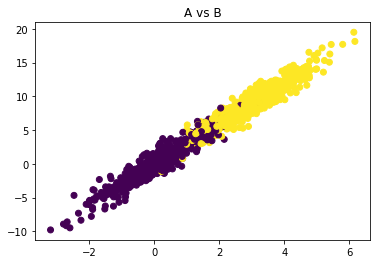

In [7]:
# plt.scatter(A,B,c=L)
#  plt.title("A vs B")

In [44]:
# model = Sequential()
# model.add(Dense(12, input_shape=(2,), activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='linear'))

In [46]:
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [49]:
# model.fit(X, B, epochs=150, batch_size=10)

Epoch 1/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9880 - mean_squared_error: 0.9880
Epoch 2/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9588 - mean_squared_error: 0.9588
Epoch 3/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9540 - mean_squared_error: 0.9540
Epoch 4/150
100/100 [==============================] - 0s 1ms/step - loss: 0.9544 - mean_squared_error: 0.9544
Epoch 5/150
100/100 [==============================] - 0s 895us/step - loss: 0.9522 - mean_squared_error: 0.9522
Epoch 6/150
100/100 [==============================] - 0s 790us/step - loss: 0.9512 - mean_squared_error: 0.9512
Epoch 7/150
100/100 [==============================] - 0s 718us/step - loss: 0.9522 - mean_squared_error: 0.9522
Epoch 8/150
100/100 [==============================] - 0s 688us/step - loss: 0.9524 - mean_squared_error: 0.9524
Epoch 9/150
100/100 [==============================] - 0s 688us/step - loss: 0.9525 - mean_squared_error

In [52]:
# plt.scatter(A,B,c=L)
# plt.scatter(A,model.predict(X_ones))
#z=model.predict(X)
#z.reshape((len(z,)))

array([-3.14180516e-02,  2.47345380e-02, -1.15890019e-02, -2.03124061e-03,
        1.07470915e-01, -3.23055118e-01, -1.50413066e-02, -7.92838484e-02,
       -1.40724853e-01,  5.30860946e-03, -1.01981834e-01, -1.53320916e-02,
        6.08446412e-02, -3.13251726e-02, -1.51612237e-02,  6.44705892e-02,
        4.61843237e-03, -1.09218284e-02,  4.97352704e-03, -2.98522152e-02,
       -1.46527104e-02, -1.79014988e-02,  2.46982619e-01,  1.06884480e-01,
        2.65546851e-02,  1.30092189e-01,  1.03865296e-01,  9.78301093e-03,
       -2.55147628e-02,  5.99350780e-04,  1.12908147e-02, -1.36290506e-01,
        1.33417957e-02, -2.45578177e-02, -7.73887783e-02, -9.02772397e-02,
       -5.02265878e-02,  3.08751278e-02, -8.33608508e-02, -9.87681374e-03,
       -3.33339088e-02,  7.07734600e-02,  5.20612635e-02, -4.25149709e-01,
       -5.97749464e-02, -1.11680292e-02,  1.45510331e-01, -2.71519162e-02,
       -1.95415206e-02, -7.74633139e-02,  1.21133655e-01,  7.72000700e-02,
        1.44963674e-02,  

In [48]:
# X=np.vstack((L,A)).T

In [31]:
# X_ones=np.vstack((L_ones,A)).T

In [29]:
# L_ones=np.ones((L.shape))
# # #print(L_ones)
# L_minus=np.ones((L.shape))*leftside

In [30]:
# X_zero=np.vstack((L_minus,A)).T

In [6]:
# regressor.fit(X, B_strat)

In [27]:
# y_pred = regressor.predict([[0,2]])

In [4]:
# B_strat=stratifydata(L,B)

In [3]:
# plt.scatter(A, B_strat,c=L)
# plt.scatter(A, regressor.predict(X_zero), color = 'blue',label='L=0')
# plt.scatter(A,regressor.predict(X_one),color='red',label='L=1')
# plt.title('Stratitifed data (SVR)')
# plt.xlabel('A with L ')
# plt.ylabel('B')
# plt.legend()
# plt.show()

In [ ]:
# # Predicting the target values of the test set
# # y_pred = model.predict(X)

# # RMSE (Root Mean Square Error)
# rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
# print("\nRMSE: ", rmse)